In [399]:
import os
import sys

import random
import numpy as np
import scipy as sp
import pandas as pd

from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics

In [400]:
def compute_matrices(m1, m2, num_reports):
    print(m1.shape)
    print(m2.shape)
    A = (m1.T @ m2)
    B = (m1.sum(0).reshape((m1.shape[1],1)) - A)
    B[B==0] = 1
    C = (m2.sum(0) - A)
    C[C==0] = 1
    D = (num_reports-(A+B+C))
    
    PRR = ((A/B)/(C/D))
    Tc = A/(A+B+C)

    return {
        'A': A,
        'B': B,
        'C': C,
        'D': D,
        'PRR': PRR,
        'Tc': Tc
    }

def build_dataframe(matrices, ordered_m1, m1_name, ordered_m2, m2_name, m12label=None, m22label=None, minA=10):
    
    mask = matrices['A']>=minA
    indices = np.where(mask)
    dfdata = {}

    dfdata[m1_name] = [ordered_m1[i] for i in indices[0]]
    if m12label is not None:
        dfdata[f"{m1_name}_label"] = [m12label.get(ordered_m1[i], i) for i in indices[0]]
    
    dfdata[m2_name] = [ordered_m2[i] for i in indices[1]]
    if m22label is not None:
        dfdata[f"{m2_name}_label"] = [m22label.get(ordered_m2[i], i) for i in indices[1]]

    for key, mat in matrices.items():
        dfdata[key] = mat[mask]

    return pd.DataFrame(dfdata)

In [403]:
ndrugs = 25

drugs = list()
for drug in range(ndrugs):
    for _ in range(random.randint(1, 10)):
        drugs.append(f"D{drug}")

drug_probs = pd.Series(drugs).value_counts(normalize=True)
# drug_probs

In [404]:
nreactions = 50

reactions = list()
for reaction in range(nreactions):
    for _ in range(random.randint(2,10)):
        reactions.append(f"Rxn{reaction}")

rxn_probs = pd.Series(reactions).value_counts(normalize=True)
# rxn_probs

In [405]:
nindications = 30
indications = list()
for indication in range(nindications):
    for _ in range(random.randint(1, 10)):
        indications.append(f"I{indication}")

ind_probs = pd.Series(indications).value_counts(normalize=True)

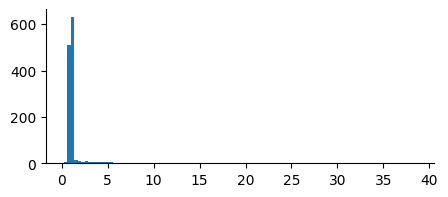

In [406]:
drug_rxn_factors = dict()
drug_rxn_truth = dict()

proportion_true = 0.10

for drug in drug_probs.index:
    for rxn in rxn_probs.index:
        if np.random.rand() <= proportion_true:
            # true drug->reactions relationships
            factor = np.exp(np.random.normal(1, 1))
            drug_rxn_truth[(drug,rxn)] = 1.0
        else:
            # not true relatinoship 
            factor = np.exp(np.random.normal(0, 0.1))
            drug_rxn_truth[(drug,rxn)] = 0.0
        drug_rxn_factors[(drug,rxn)] = factor

drf = list()
for drug in drug_probs.index:
    drf.append([drug_rxn_factors[(drug, rxn)] for rxn in rxn_probs.index])

plt.figure(figsize=(5,2))
# plt.hist(np.log(list(drug_rxn_factors.values())), bins=100)
plt.hist(drug_rxn_factors.values(), bins=100)
sns.despine()

In [555]:
nreports = 10000

reports = list()

for rid in range(nreports):
    drugid = np.random.choice(len(drug_probs), 1, True, p=drug_probs)[0]
    adjusted_probs = drf[drugid]*rxn_probs
    adjusted_probs /= (adjusted_probs).sum()
    rxnid = np.random.choice(len(rxn_probs), 1, True, p=adjusted_probs)[0]
    reports.append([rid, drugid, rxnid])

# drugs, rxns

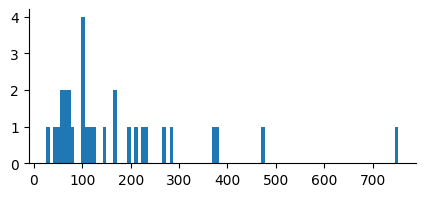

In [556]:
ind_rxn_factors = dict()

for ind in ind_probs.index:
    # randomly select one reaction that this indication will cause
    rxnid = np.random.choice(len(rxn_probs), 1, True)[0]
    rxn = rxn_probs.index[rxnid]
    # indications cause big reactions
    factor = np.exp(np.random.normal(5, 1))
    ind_rxn_factors[(ind,rxn)] = factor

irf = list()
for ind in ind_probs.index:
    irf.append([ind_rxn_factors.get((ind, rxn), 1.0) for rxn in rxn_probs.index])

plt.figure(figsize=(5,2))
# plt.hist(np.log(list(drug_rxn_factors.values())), bins=100)
plt.hist(ind_rxn_factors.values(), bins=100)
sns.despine()

In [557]:
# establish correlations between drugs and indications

drug_indid_probs = defaultdict(dict)
for drug in drug_probs.index:
    num_inds = max(1, np.random.poisson(lam=2))
    random_inds = np.random.choice(len(ind_probs), num_inds, False)
    inds = list()
    for ind in random_inds:
        for _ in range(random.randint(2,10)):
            inds.append(ind)
    
    diprobs = pd.Series(inds).value_counts(normalize=True)
    for ind, prob in diprobs.items():
        drug_indid_probs[drug][ind] = prob

# plt.hist(drug_ind_probs.values());
# drug_indid_probs

In [566]:
# build report x drug, report by rxn, and report by indication matrices

# reports by drugs
drugs = np.zeros(shape=(nreports, len(drug_probs)))
# reports by reactions
rxns = np.zeros(shape=(nreports, len(rxn_probs)))
# reports by indications
inds = np.zeros(shape=(nreports, len(ind_probs)))

for rid, drugid, rxnid in reports:
    
    # first add the drug and the reaction
    drugs[rid, drugid] = 1
    rxns[rid, rxnid] = 1

    # check to see if the drug's indications add any reactions to this report
    indids, probs = zip(*drug_indid_probs[drug_probs.index[drugid]].items())
    indid = np.random.choice(indids, 1, True, p=probs)[0]
    ind = ind_probs.index[indid][0]

    adjusted_probs = irf[indid]*rxn_probs
    adjusted_probs /= (adjusted_probs).sum()
    rxnid = np.random.choice(len(rxn_probs), 1, True, p=adjusted_probs)[0]
    inds[rid, indid] = 1
    rxns[rid, rxnid] = 1
    

In [574]:
type(drugs)

numpy.ndarray

In [567]:
# A = (drugs.T @ rxns)
# print(A.shape, drugs.sum(0).reshape((10,1)).shape)
# B = (drugs.sum(0).reshape((drugs.shape[1],1))-A)
# drugs.shape, rxns.shape, drugs.sum(0).shape

In [568]:
matrices = compute_matrices(drugs, rxns, num_reports=nreports)
drug_rxn = build_dataframe(matrices, drug_probs.index, 'drug', rxn_probs.index, 'reaction', minA=1)
drug_rxn['factor'] = [drug_rxn_factors[(d,r)] for _, (d, r) in drug_rxn[['drug', 'reaction']].iterrows()]
drug_rxn['truth'] = [drug_rxn_truth[(d, r)] for _, (d, r) in drug_rxn[['drug', 'reaction']].iterrows()]
drug_rxn.sort_values(by='PRR', ascending=False).head(5)

(10000, 25)
(10000, 50)


,drug,reaction,A,B,C,D,PRR,Tc,factor,truth
1095,D10,Rxn21,63.0,10.0,228.0,9699.0,267.998684,0.209302,0.927465,0.0
197,D8,Rxn16,551.0,195.0,118.0,9136.0,218.771664,0.637731,0.927195,0.0
1064,D13,Rxn40,61.0,16.0,384.0,9539.0,94.706868,0.132321,0.863634,0.0
418,D21,Rxn2,376.0,63.0,570.0,8991.0,94.141353,0.372646,1.134439,0.0
48,D16,Rxn46,611.0,239.0,561.0,8589.0,39.140201,0.433026,1.041682,0.0


In [569]:
matrices = compute_matrices(inds, rxns, num_reports=nreports)
ind_rxn = build_dataframe(matrices, ind_probs.index, 'indication', rxn_probs.index, 'reaction', minA=1)
ind_rxn.sort_values(by='PRR', ascending=False).head()

(10000, 30)
(10000, 50)


,indication,reaction,A,B,C,D,PRR,Tc
1054,I21,Rxn40,305.0,75.0,140.0,9480.0,275.371429,0.586538
798,I18,Rxn21,63.0,10.0,228.0,9699.0,267.998684,0.209302
506,I26,Rxn2,692.0,109.0,254.0,8945.0,223.576537,0.655924
386,I19,Rxn16,551.0,195.0,118.0,9136.0,218.771664,0.637731
313,I20,Rxn39,209.0,13.0,783.0,8995.0,184.689557,0.207960


In [570]:
matrices = compute_matrices(inds, drugs, num_reports=nreports)
ind_ing = build_dataframe(matrices, ind_probs.index, 'indication', drug_probs.index, 'drug', minA=1)
ind_ing.sort_values(by='PRR', ascending=False).head()

(10000, 30)
(10000, 25)


,indication,drug,A,B,C,D,PRR,Tc
14,I19,D8,746.0,1.0,1.0,9252.0,6.901992e+06,0.997326
31,I18,D10,73.0,1.0,1.0,9925.0,7.245250e+05,0.973333
21,I16,D20,681.0,304.0,1.0,9014.0,2.019255e+04,0.690669
0,I8,D5,165.0,1.0,80.0,9754.0,2.011762e+04,0.670732
3,I25,D16,850.0,495.0,1.0,8654.0,1.486040e+04,0.631501


In [571]:
# matrices = compute_matrices(drugs, drugs, num_reports=nreports)

# ing_ing = build_dataframe(matrices,
#                           drug_probs.index, 'ingredient1',
#                           drug_probs.index, 'ingredient2',
#                           minA=1)

# ing_ing = ing_ing[ing_ing['ingredient1'] != ing_ing['ingredient2']]
# ing_ing.sort_values(by='Tc', ascending=False).head(10)

Ind PRRs greatrer than 10: 51
(51, 6)


SignificanceResult(statistic=0.745989728465327, pvalue=3.3436550132642363e-10)

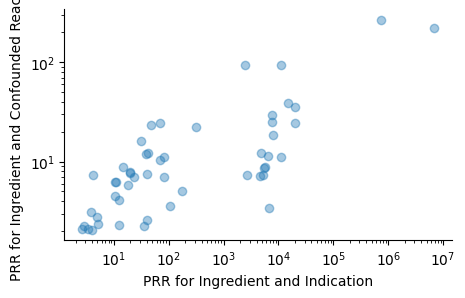

In [572]:
# build datafraem to look at confounding by indication
ind_keep = ['drug', 
        'reaction', 
        'indication',
        'PRR_ing_rxn',
        'PRR_ind_ing',
        'PRR_ind_rxn']
ind_merged = drug_rxn.merge(ind_ing, 
                            on='drug',
                            suffixes=('_ing_rxn', '_ind_ing')
                          ).merge(ind_rxn,
                            on=('indication', 'reaction',),
                            suffixes=('', '_ind_rxn'))

ind_merged.rename(columns={'PRR': 'PRR_ind_rxn'}, inplace=True)
ind_reduced = ind_merged[ind_keep]
# reduced[reduced['reaction']=='35506628'].head()

# plt.figure(figsize=(5,3))
# plt.hist(ind_reduced[ind_reduced['PRR_ind_rxn']>1]['PRR_ind_rxn'], bins=100)

print(f"Ind PRRs greatrer than 10: {(ind_reduced['PRR_ind_rxn'] > 10).sum()}")

# we only care about whent the relationship between the indication and the reaction is high
ind_rxn_high = ind_reduced[ind_reduced['PRR_ind_rxn'] > 10]
print(ind_rxn_high.shape)

plt.figure(figsize=(5,3))
plt.scatter(ind_rxn_high['PRR_ind_ing'], ind_rxn_high['PRR_ing_rxn'], alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('PRR for Ingredient and Indication')
plt.ylabel('PRR for Ingredient and Confounded Reaction')
sns.despine()

sp.stats.spearmanr(ind_rxn_high['PRR_ind_ing'], ind_rxn_high['PRR_ing_rxn'])

Tc: SignificanceResult(statistic=0.1980334868926225, pvalue=5.25795643572028e-12)
PRR: SignificanceResult(statistic=0.24605911704553274, pvalue=6.7412474876345605e-18)
Tc AUROC: 0.725 AUPR: 0.282
PRR AUROC: 0.752 AUPR: 0.311


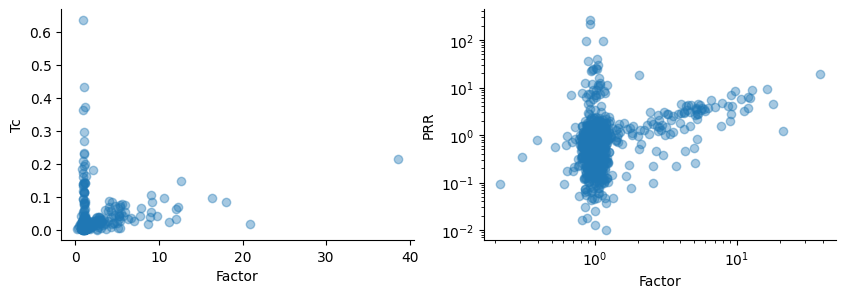

In [573]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.scatter(drug_rxn['factor'], drug_rxn['Tc'], alpha=0.4)
plt.xlabel('Factor')
# plt.xscale('log')
plt.ylabel('Tc')
sns.despine()
plt.subplot(1,2,2)
plt.scatter(drug_rxn['factor'], drug_rxn['PRR'], alpha=0.4)
plt.xlabel('Factor')
plt.xscale('log')
plt.ylabel('PRR')
plt.yscale('log')
sns.despine()

print(f"Tc: {sp.stats.spearmanr(drug_rxn['factor'], drug_rxn['Tc'])}")
print(f"PRR: {sp.stats.spearmanr(drug_rxn['factor'], drug_rxn['PRR'])}")
print(f"Tc AUROC: {sklearn.metrics.roc_auc_score(drug_rxn['truth'], drug_rxn['Tc']):.3f} AUPR: {sklearn.metrics.average_precision_score(drug_rxn['truth'], drug_rxn['Tc']):.3f}")
print(f"PRR AUROC: {sklearn.metrics.roc_auc_score(drug_rxn['truth'], drug_rxn['PRR']):.3f} AUPR: {sklearn.metrics.average_precision_score(drug_rxn['truth'], drug_rxn['PRR']):.3f}")

In [575]:
sklearn.metrics

<module 'sklearn.metrics' from '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/__init__.py'>